##PROBLEM 5 : Implement Kernel PCA for linear regression

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import requests

In [10]:
def get_data(url,identifier):
  response = requests.get(url)
  data = response.text
  lines = data.splitlines()
  processed_data = []
  for line in lines:
    if identifier == 'spiral':
      components = line.split()
    else:
      components = line.split(',')
    processed_data.append([float(component) for component in components])
  return np.array(processed_data)

In [11]:
spiral_url = "https://www.khoury.northeastern.edu/home/vip/teach/DMcourse/data/TwoSpirals/twoSpirals.txt"
circles_url = "https://www.khoury.northeastern.edu/home/vip/teach/DMcourse/data/TwoSpirals/threecircles.txt"

In [12]:
spirals = get_data(spiral_url,'spiral')
circles = get_data(circles_url,'circles')

####A) First, train a Linear Regression (library) and confirm that it doesnt work , i.e. it has a high classification error or high Root Mean Squared Error.

In [26]:
circles_data_train, circles_data_test, circles_lbl_train, circles_lbl_test = train_test_split(circles[:,:2], circles[:,-1], test_size=0.2, random_state=42)
spirals_data_train, spirals_data_test, spirals_lbl_train, spirals_lbl_test = train_test_split(spirals[:,:2], spirals[:,-1], test_size=0.2, random_state=42)

#####Visualization

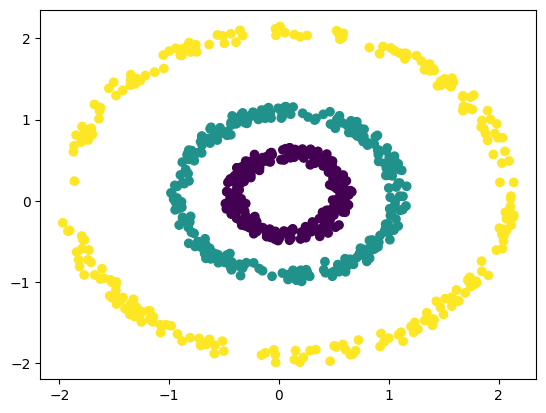

In [31]:
plt.scatter(circles_data_train[:,0],circles_data_train[:,1],c=circles_lbl_train)

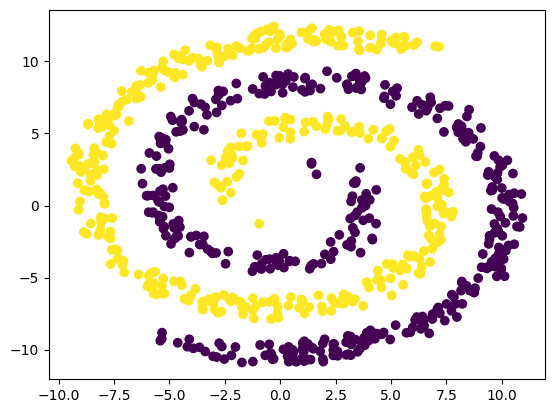

In [32]:
plt.scatter(spirals_data_train[:,0],spirals_data_train[:,1],c=spirals_lbl_train)

#####Training Logistic Regression

In [231]:
log_reg_circles = LogisticRegression()
log_reg_circles.fit(circles_data_train,circles_lbl_train)

log_reg_spirals = LogisticRegression()
log_reg_spirals.fit(spirals_data_train,spirals_lbl_train)

LogisticRegression()

In [232]:
circles_pred = log_reg_circles.predict(circles_data_test)
accuracy = accuracy_score(circles_lbl_test, circles_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
class_report = classification_report(circles_lbl_test, circles_pred)
print("Classification Report:")
print(class_report)

Accuracy: 0.2750
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.20      0.14      0.16        71
         0.0       0.29      0.32      0.30        63
         1.0       0.31      0.38      0.34        66

    accuracy                           0.28       200
   macro avg       0.27      0.28      0.27       200
weighted avg       0.26      0.28      0.27       200



In [37]:
spirals_pred = log_reg_spirals.predict(spirals_data_test)
accuracy = accuracy_score(spirals_lbl_test, spirals_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
class_report = classification_report(spirals_lbl_test, spirals_pred)
print("Classification Report:")
print(class_report)

Accuracy: 0.6650
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.66      0.62      0.64        96
         1.0       0.67      0.70      0.69       104

    accuracy                           0.67       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.66      0.67      0.66       200



####B) Run KernelPCA with Gaussian Kernel to obtain a representation of T features.

In [367]:
def kernel_pca(X):
  # X2 = dot(X,X,2);
  X2 = np.sum(X**2, axis=1).reshape(-1, 1)

  # DIST_euclid = bsxfun(@plus, X2, X2') - 2 * X * X';
  DIST_euclid = X2 + X2.T - 2 * np.matmul(X, X.T)

  # sigma = 3;
  sigma = 3

  # K = exp(-DIST_euclid/sigma);
  K = np.exp(-DIST_euclid / sigma)

  # U = ones(N)/ N ;
  N = K.shape[0]
  U = np.ones((N, N)) / N

  # Kn = K - U*K - K*U + U*K*U ;
  Kn = K - U @ K - K @ U + U @ K @ U

  # V, D = eig(Kn,'vector');
  D, V = np.linalg.eigh(Kn)  # eigh computes eigenvalues and eigenvectors for symmetric matrices

  # Sort eigenvalues and eigenvectors
  sorted_indices = np.argsort(D)[::-1]  # Sort in descending order
  D = D[sorted_indices]
  V = V[:, sorted_indices]

  # XG = Kn*V';
  XG = Kn @ V.T

  return XG

In [386]:
circles_ = kernel_pca(circles[:,:2])
spirals_ = kernel_pca(spirals[:,:2])

In [387]:
circles_.shape

(1000, 1000)

In [388]:
spirals_.shape

(1000, 1000)

####C) Retrain Linear regression on the transformed D-dim data. How large D needs to be to get good performance?

#####Circles

In [389]:
# Confusion: How to project Test data to 800 (kernel matrix dim: 200x200) (Projection mat dim: 800x3)
def retrainDdim(transformed_ds,lbls,d):
  X_d = transformed_ds[:,:d]
  X_d_train, X_d_test, y_train, y_test = train_test_split(X_d, lbls, test_size=0.2, random_state=42)

  log_reg = LogisticRegression()
  log_reg.fit(X_d_train,y_train)

  y_pred = log_reg.predict(X_d_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy:.4f}")

  class_report = classification_report(y_test, y_pred)
  print("Classification Report:")
  print(class_report)

In [212]:
# Performance w/o kpca

Accuracy: 0.2750
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.20      0.14      0.16        71
         0.0       0.29      0.32      0.30        63
         1.0       0.31      0.38      0.34        66

    accuracy                           0.28       200
   macro avg       0.27      0.28      0.27       200
weighted avg       0.26      0.28      0.27       200




In [ ]:
# For circles we can get good performance from D = 4 and get 100% accuracy on D = 8

In [402]:
retrainDdim(circles_,circles[:,-1],4)

Accuracy: 0.9100
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.81      0.99      0.89        71
         0.0       0.98      0.73      0.84        63
         1.0       0.99      1.00      0.99        66

    accuracy                           0.91       200
   macro avg       0.93      0.91      0.91       200
weighted avg       0.92      0.91      0.91       200



In [398]:
retrainDdim(circles_,circles[:,-1],8)

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        71
         0.0       1.00      1.00      1.00        63
         1.0       1.00      1.00      1.00        66

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [404]:
# Performance w/o kpca

Accuracy: 0.6650
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.66      0.62      0.64        96
         1.0       0.67      0.70      0.69       104

    accuracy                           0.67       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.66      0.67      0.66       200


In [ ]:
# For spirals we can get good performance from D = 16 and get 98.5% accuracy on D = 25

In [428]:
retrainDdim(spirals_,spirals[:,-1],16)

Accuracy: 0.9050
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.85      0.98      0.91        96
         1.0       0.98      0.84      0.90       104

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



In [420]:
retrainDdim(spirals_,spirals[:,-1],25)

Accuracy: 0.9850
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.97      1.00      0.98        96
         1.0       1.00      0.97      0.99       104

    accuracy                           0.98       200
   macro avg       0.98      0.99      0.98       200
weighted avg       0.99      0.98      0.99       200

